In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

all_dengues_week = provinces_df.resample('W').size()
all_dengues_week_df = pd.DataFrame(all_dengues_week,columns=['cases'])
all_train_test_week = split_data(all_dengues_week_df)
all_dengues_train_week, all_dengues_test_week = all_train_test_week[0], all_train_test_week[1]

In [148]:
# all_dengues_train_mth

In [96]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(predictions)+start_week)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week+25),3000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$ARIMA (1, 1, 0) \times (0, 1, 0)$$

$$\hat{Y}_{t} - Y_{t - 12} = \mu + (Y_{t-1} -\, Y_{t-13}) + \phi\,(Y_{t-1} - Y_{t-2})$$

$$\hat{Y}_{t} = \mu + Y_{t - 12} + (Y_{t-1} -\, Y_{t-13}) + \phi\,(Y_{t-1} - Y_{t-2})$$

If the ACF model shows autocorrelation and stationary, perhaps the problem can be fixed by adding one lag of the dependent variable to the prediction equation--i.e., by regressing the first difference of Y on itself lagged by one period.

This is a first-order autoregressive model with one order of nonseasonal differencing, one order of seasonale differencing, and a constant term

In [84]:
train_week = all_dengues_train_week
test_week = all_dengues_test_week
train_test_week = all_dengues_week_df.cases

def guess(w,y_cases): # should take in two w's
    y_12 = y_cases[4]
    y_13 = y_cases[0]
    y_1 = y_cases[-4]
    y_2 = y_cases[-8]
    s_diff = y_1 - y_13
    nons_diff = y_1 - y_2
    return w[0] + y_12 + s_diff + (w[1]*nons_diff)

def cost(w):
    ret = 0
    for i in range(len(train_week)-56):
        real_case = train_week[i+56]
#         print train_week[i:i+56][0],train_week[i:i+56][-1]
#         print 'real',real_case
        predicted_case = guess(w,train_week[i:i+56])
        sigma_sq = real_case + 1
        ret += ((real_case-predicted_case)**2)/float(sigma_sq)
    return ret

In [83]:
# train_week[:58]

In [85]:
arr = [20,0.]
w = minimize(cost,arr)

In [12]:
w

      fun: 74179.18840289395
 hess_inv: array([[ 43.17560677,  28.78374388],
       [ 28.78374388,  19.18916724]])
      jac: array([-0.00195312,  0.00097656])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 97
      nit: 6
     njev: 24
   status: 2
  success: False
        x: array([-4.77787312,  0.25847728])

In [86]:
prediction_ = []
for i in range(len(train_test_week)-12):
    res = guess(w.x,train_test_week[i:i+13])
    prediction_.append(res)
    
# prediction_


In [87]:
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-10,8000,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,8000,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

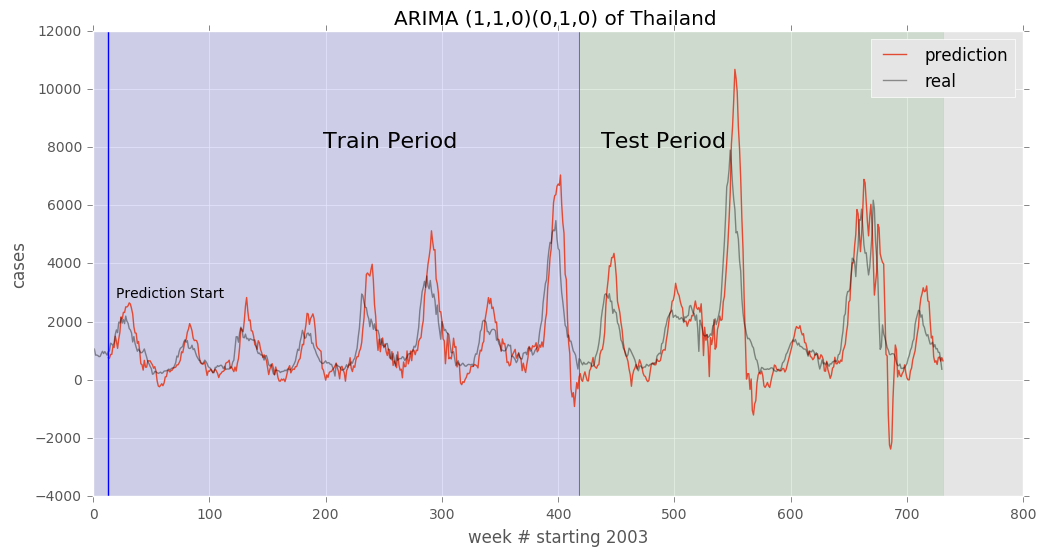

In [88]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(13,len(prediction_)+13)],prediction_,label='prediction')
plt.plot([i for i in range(len(train_test_week))],train_test_week,'-k',label='real',alpha=0.4)
plt.xlabel("week # starting 2003")
plt.ylabel("cases")
plt.title("ARIMA (1,1,0)(0,1,0) of Thailand ")
plt.axvline(13)
plt.text((13*2+40),3000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
plt.legend()
seperate_train_test(train_test_week,train_week)

In [92]:
def plot_prediction(LAG,real,ws,province,nweek_to_predict=[1,2,4,12,52]):

    def n_week_ahead(array_x,weeks_ahead):

        cur_guess = 0
        arr = np.array(array_x)
        for i in range(weeks_ahead): 
            cur_guess = guess(ws,arr)
            arr = np.append(arr[1:],cur_guess)
        return cur_guess

    for i in nweek_to_predict:
        N = LAG + (i - 1)
        predictions = []
        for j in range(len(real)-(LAG-1)):
            initial_arr = real[j:j+LAG]
            predictions.append(n_week_ahead(initial_arr,i)) 
    
        title = "%s's Dengue Prediction %d lags: %d week(s) ahead"%(province,LAG,i)
        make_line(LAG+(i-1),real,predictions,title,"# week starting 2003","cases")

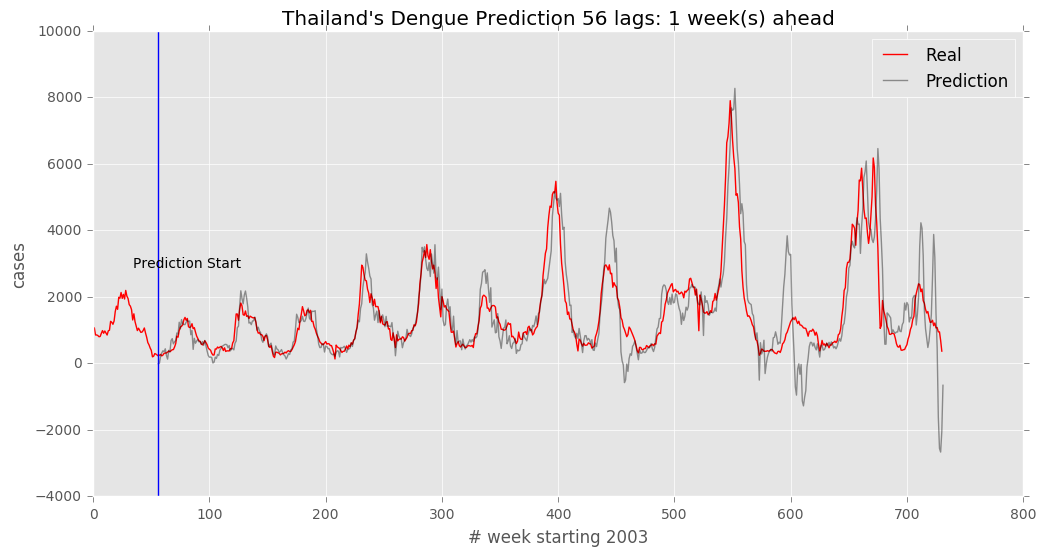

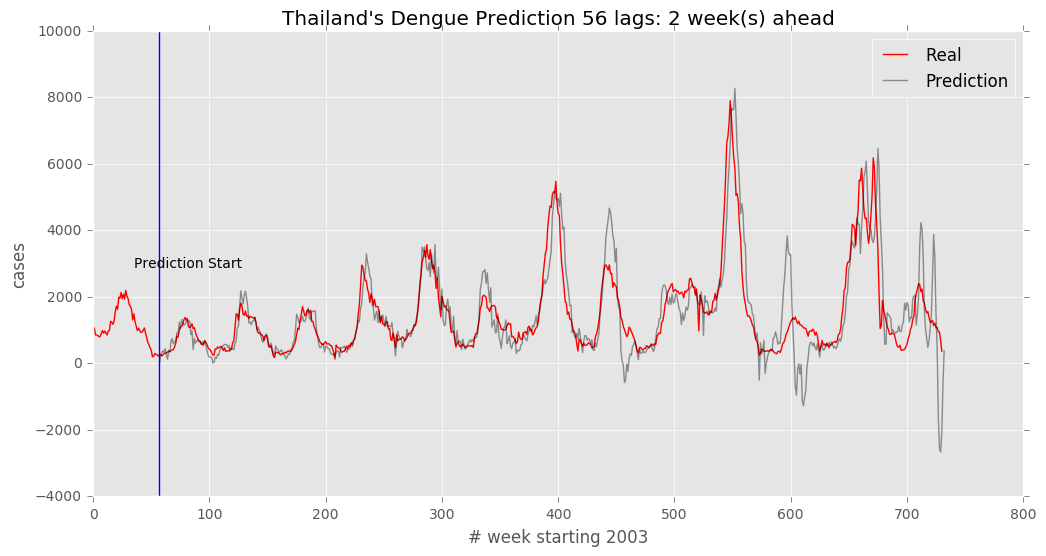

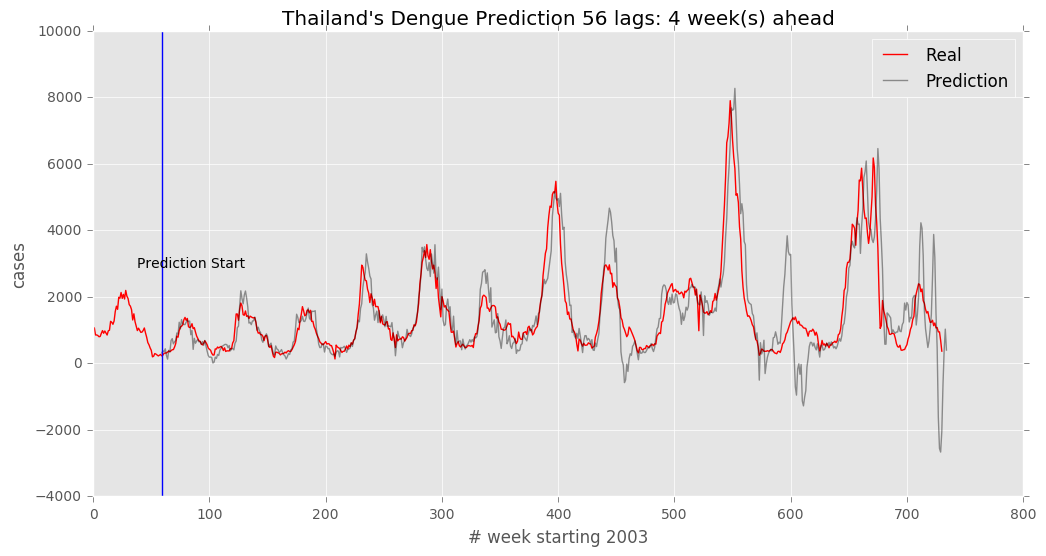

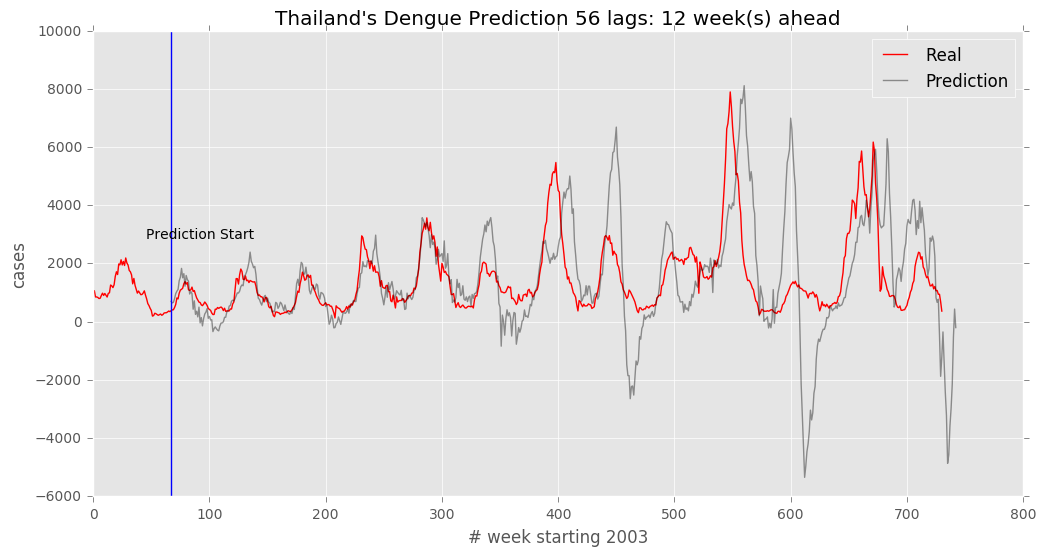

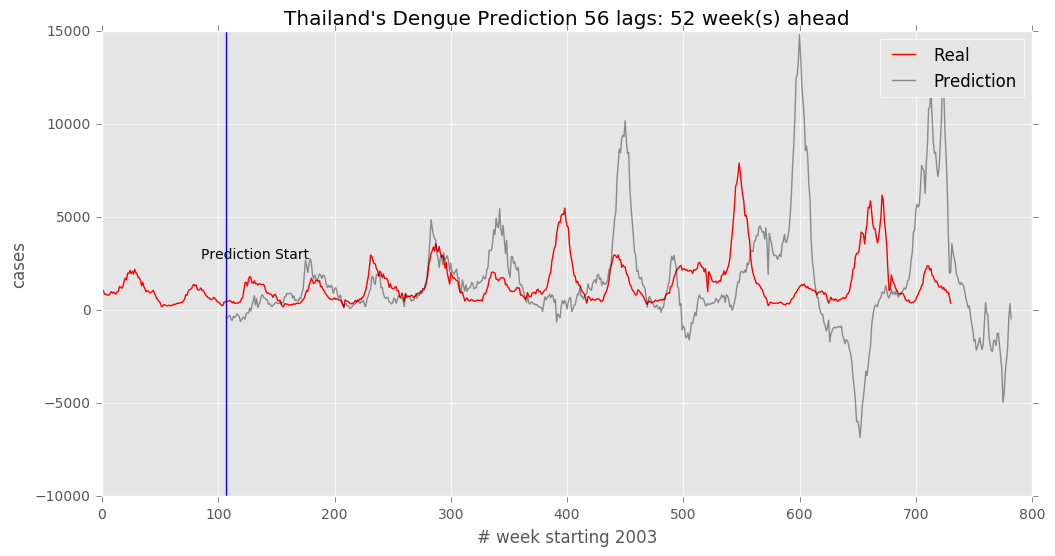

In [97]:
plot_prediction(56,train_test_week,w.x,'Thailand')

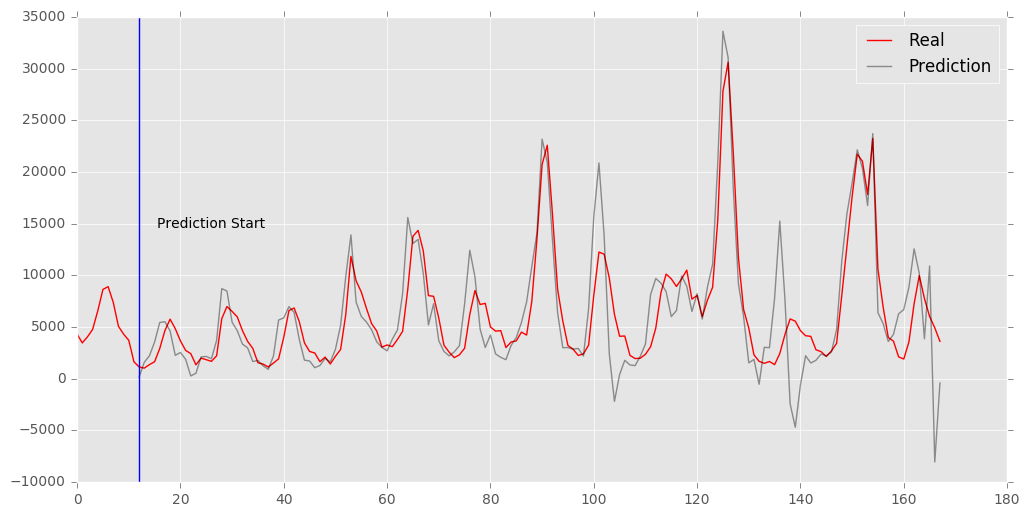

In [168]:
make_line(12,train_test,prediction_,"","","")

In [73]:
# y_12 = y_cases[1]
# y_13 = y_cases[0]
# y_1 = y_cases[12]
# y_2 = y_cases[11]

tmp = [i for i in range(56)]
print tmp
print 'y52',tmp[4]
print 'y56',tmp[0]
print 'y4',tmp[-4],tmp[52]
print 'y8',tmp[-8],tmp[48]


 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
y52 4
y56 0
y4 52 52
y8 48 48


In [63]:
wk = [i for i in range(1,31)]
print wk[-1],wk[-8],wk[-15],wk[-22],wk[-29]

30 23 16 9 2
